In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import time
import re
from collections import Counter
import math

# from TransformerModel import *

import importlib, TransformerModel, utils
importlib.reload(TransformerModel)
importlib.reload(utils)
from TransformerModel import TinyGPT
from utils import *

# Load Data

In [2]:
### ~~~~~~~~~~~~~~~~~~~~~ ###
###    token definition   ###
### ~~~~~~~~~~~~~~~~~~~~~ ###
paths = ["data/PrideAndPrejudice.txt", "data/Emma.txt", "data/SenseAndSensibility.txt"]
text = "\n".join(open(p, "r", encoding="utf-8", errors="ignore").read().lower() for p in paths)

# simple tokenizer: words or single punctuation marks
tokens = re.findall(r"[a-z]+|[0-9]+|[^\s\w]", text)
print("num tokens:", len(tokens), "unique:", len(set(tokens)))

num tokens: 314744 unique: 9376


In [3]:
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###    vocab definition, encoding   ###
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
vocab_size = 10_000
special = ["<pad>", "<unk>"]  # pad will make each token same length, unk is reserved for words not in vocab

counts = Counter(tokens)
most_common = [w for (w, _) in counts.most_common(vocab_size - len(special))]
vocab = special + most_common

# string-to-index,  index-to-string
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

# ids = entire book written in integers
ids = torch.tensor([stoi.get(tok, stoi["<unk>"]) for tok in tokens], dtype=torch.long)
print("ids shape:", ids.shape, "UNK rate:", (ids == stoi["<unk>"]).float().mean().item())

ids shape: torch.Size([314744]) UNK rate: 0.0


# Load Models

In [4]:
def load_ckpt(path, device="cpu"):
    ckpt = torch.load(path, map_location=device)
    cfg  = ckpt["config"]

    model = TinyGPT(**cfg).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    return model, ckpt

In [5]:
model_2M, ckpt_2M = load_ckpt("miniGPT_2Mparams.pt")
model_5p6M, ckpt_5p6M = load_ckpt("miniGPT_5p6Mparams.pt")

print("2M step:", ckpt_2M.get("step"), "cfg:", ckpt_2M["config"])
print("5.6M step:", ckpt_5p6M.get("step"), "cfg:", ckpt_5p6M["config"])

2M step: 100000 cfg: {'vocab_size': 9378, 'block_size': 128, 'd_model': 128, 'n_blocks': 4, 'n_heads': 4, 'd_ff': 512}
5.6M step: 50000 cfg: {'vocab_size': 9378, 'block_size': 128, 'd_model': 256, 'n_blocks': 4, 'n_heads': 4, 'd_ff': 1024}


In [6]:
# total params
n_params = sum(p.numel() for p in model_5p6M.parameters())
# (optional) trainable params
n_train  = sum(p.numel() for p in model_5p6M.parameters() if p.requires_grad)

print(f"total params: {n_params:,}")
print(f"trainable params: {n_train:,}")


total params: 5,588,992
trainable params: 5,588,992


# Attention Heatmaps

In [7]:
def get_batch(data_ids, batch_size=32, block_size=128, device="cpu"):
    # random starting indices
    ix = torch.randint(0, len(data_ids) - block_size - 1, (batch_size,))
    x = torch.stack([data_ids[i:i+block_size] for i in ix]).to(device)  ## random sentence / phrase
    y = torch.stack([data_ids[i+1:i+block_size+1] for i in ix]).to(device) ## shifted sentence / phrase
    return x, y

In [8]:
@torch.no_grad()
def get_repeat_vs_control_attn(
    model, ids, itos, 
    L=16, batch_size=1000, n_chunks=4, print_text=True,
):
    """
    Builds idx_rep=[base]*n_chunks and idx_ctl=[base, rand2, rand3, ...],
    runs model(return_attn=True), and returns (idx_rep, idx_ctl, attn_rep, attn_ctl).

    attn_* is a list of length n_blocks; each element is (B, n_heads, T, T).
    """

    device = next(model.parameters()).device

    base, _ = get_batch(ids, batch_size=batch_size, block_size=L, device=device)
    reps = [base] * n_chunks
    idx_rep = torch.cat(reps, dim=1)

    rands = [get_batch(ids, batch_size=batch_size, block_size=L, device=device)[0]
             for _ in range(n_chunks - 1)]
    idx_ctl = torch.cat([base] + rands, dim=1)

    _, attn_rep = model(idx_rep, return_attn=True)
    _, attn_ctl = model(idx_ctl, return_attn=True)

    if print_text:
        txt_rep = " ".join(itos[i] for i in idx_rep[0].tolist())
        txt_ctl = " ".join(itos[i] for i in idx_ctl[0].tolist())
        print("TEXT (repeat):\n", txt_rep)
        print("\nTEXT (control):\n", txt_ctl)

    return idx_rep, idx_ctl, attn_rep, attn_ctl


In [9]:
# Get batches for 'Repeat' and 'control' blocks of text
idx_rep_2M, idx_ctl_2M, attn_rep_2M, attn_ctl_2M = get_repeat_vs_control_attn(
    model_2M, ids, itos, L=16, batch_size=2000, n_chunks=4, print_text=True
)

idx_rep_5p6M, idx_ctl_5p6M, attn_rep_5p6M, attn_ctl_5p6M = get_repeat_vs_control_attn(
    model_5p6M, ids, itos, L=16, batch_size=2000, n_chunks=4, print_text=True
)



TEXT (repeat):
 other people . the motive was too common to be wondered at ; but the means other people . the motive was too common to be wondered at ; but the means other people . the motive was too common to be wondered at ; but the means other people . the motive was too common to be wondered at ; but the means

TEXT (control):
 other people . the motive was too common to be wondered at ; but the means was the only one who shed tears ; but she did weep from vexation and envy for after undergoing an examination into the value and make of her gown , the colour world , which is always the way with her , for she has , without exception
TEXT (repeat):
 receive her sister - in - law on her arrival , and treat her with proper receive her sister - in - law on her arrival , and treat her with proper receive her sister - in - law on her arrival , and treat her with proper receive her sister - in - law on her arrival , and treat her with proper

TEXT (control):
 receive her sister - in - law o

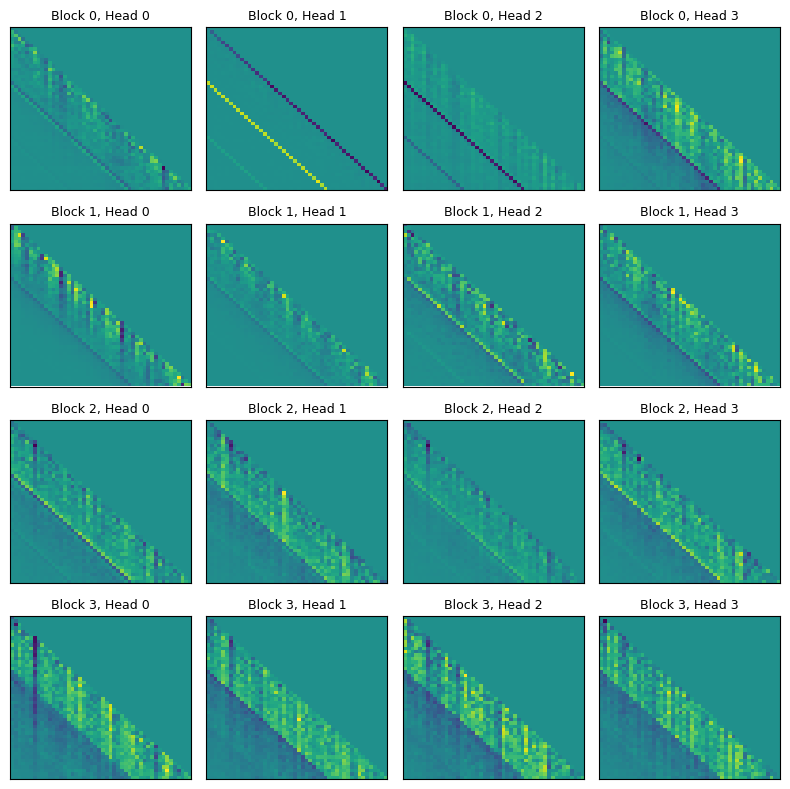

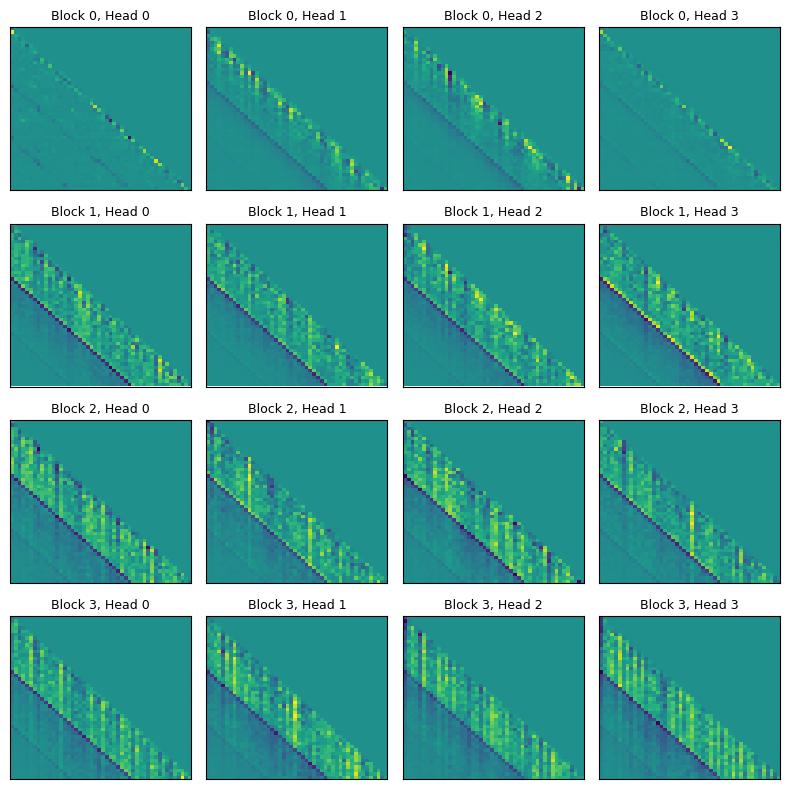

In [19]:
plot_delta_heads(idx_rep_2M, idx_ctl_2M, attn_rep_2M, attn_ctl_2M, itos, zoom=False, L=16, k=1)
print('\n\n')
plot_delta_heads(idx_rep_5p6M, idx_ctl_5p6M, attn_rep_5p6M, attn_ctl_5p6M, itos, zoom=False, L=16, k=1)

# Head Ablations

In [27]:
def plot_ablation_results(df_heads, 
                          df_blocks, 
                          df_cum, 
                          title
                         ):
    n_blocks = int(df_heads["block"].max()) + 1
    n_heads  = int(df_heads["head"].max()) + 1

    # Head heatmap
    A = heatmap_df(df_heads, n_blocks, n_heads, "delta_drop")
    fig, ax = plt.subplots(figsize=(1.2*n_heads + 2, 1.0*n_blocks + 2))
    im = ax.imshow(A, aspect="auto")
    ax.set_title(f"{title}: single-head ablation importance")
    ax.set_xlabel("head"); ax.set_ylabel("block")
    ax.set_xticks(range(n_heads)); ax.set_yticks(range(n_blocks))
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("delta_drop = base_delta - ablated_delta (bigger => more important)")
    plt.tight_layout()

    # Block ablation
    fig, ax = plt.subplots(figsize=(6.5, 3.0))
    ax.bar(df_blocks["block"].astype(int).values, df_blocks["delta_drop"].values)
    ax.set_title(f"{title}: ablate ALL heads in block")
    ax.set_xlabel("block"); ax.set_ylabel("delta_drop")
    ax.set_xticks(df_blocks["block"].astype(int).values)
    plt.tight_layout()

    # Cumulative top-k curve
    fig, ax = plt.subplots(figsize=(6.5, 3.0))
    ax.plot(df_cum["k"].values, df_cum["delta_mean"].values, marker="o")
    ax.set_title(f"{title}: cumulative ablation of top-k heads")
    ax.set_xlabel("k (heads ablated)")
    ax.set_ylabel("delta_mean = ctl_loss - rep_loss")
    plt.tight_layout()

    plt.show()

In [28]:
def run_ablation_study(
    model,
    idx_rep,
    idx_ctl,
    name="model",
    L=16,
    micro_bs=256,
    topk=8,
    chunk_ks=None,
):
    n_blocks, n_heads = infer_n_blocks_heads(model, idx_rep) 

    # Baseline study ... comptues the loss (avg NLL) with no ablation
    base = rep_ctl_chunk_delta(
        model, idx_rep, idx_ctl, L=L, chunk_ks=chunk_ks, micro_bs=micro_bs, ablate=None
    )
    base_delta = base["delta_mean"]
    print(f"\n[{name}] baseline loss means:\n rep={base['rep_loss_mean']:.4f}  ctl={base['ctl_loss_mean']:.4f}  delta={base_delta:.4f}")

    # ---- single-head sweep ----
    # print('')
    # print(' ... sweeping over blocks, heads ... ')
    # print('')
    rows = []
    for b in range(n_blocks):
        for h in range(n_heads):
            # print(f'on block, head: {b, h}')
            ab = [(b, h)]
            out = rep_ctl_chunk_delta(
                model, idx_rep, idx_ctl, L=L, chunk_ks=base["chunk_ks"], micro_bs=micro_bs, ablate=ab
            )
            rows.append({
                "model": name,
                "block": b,
                "head": h,
                "delta_mean": out["delta_mean"],
                "delta_drop": base_delta - out["delta_mean"],
                "rep_loss_increase": out["rep_loss_mean"] - base["rep_loss_mean"],
                "ctl_loss_increase": out["ctl_loss_mean"] - base["ctl_loss_mean"],
            })
    df_heads = pd.DataFrame(rows).sort_values("delta_drop", ascending=False).reset_index(drop=True)

    print(f"\n[{name}] top heads (by delta_drop):")
    print(df_heads.head(10)[["block","head","delta_drop","delta_mean","rep_loss_increase","ctl_loss_increase"]])

    # ---- block ablation (all heads in a block) ----
    rows = []
    for b in range(n_blocks):
        ab = [(b, h) for h in range(n_heads)]
        out = rep_ctl_chunk_delta(
            model, idx_rep, idx_ctl, L=L, chunk_ks=base["chunk_ks"], micro_bs=micro_bs, ablate=ab
        )
        rows.append({"model": name, "block": b, "delta_mean": out["delta_mean"], "delta_drop": base_delta - out["delta_mean"]})
    df_blocks = pd.DataFrame(rows).sort_values("delta_drop", ascending=False).reset_index(drop=True)

    print(f"\n[{name}] blocks (all-head ablation) by delta_drop:")
    print(df_blocks[["block","delta_drop","delta_mean"]])

    # ---- cumulative top-k heads ----
    top_pairs = [(int(r.block), int(r.head)) for r in df_heads.head(topk).itertuples(index=False)]
    cum_rows = []
    for k in range(0, len(top_pairs)+1):
        ab = None if k == 0 else top_pairs[:k]
        out = rep_ctl_chunk_delta(
            model, idx_rep, idx_ctl, L=L, chunk_ks=base["chunk_ks"], micro_bs=micro_bs, ablate=ab
        )
        cum_rows.append({"model": name, "k": k, "delta_mean": out["delta_mean"], "rep_loss_mean": out["rep_loss_mean"], "ctl_loss_mean": out["ctl_loss_mean"]})
    df_cum = pd.DataFrame(cum_rows)
    print(f'df heads ... ... ... {df_heads}')
    plot_ablation_results(df_heads, 
                          df_blocks.sort_values("block"),
                          df_cum, 
                          title=name)

    return None
    # {"base": base, "df_heads": df_heads, "df_blocks": df_blocks, "df_cum": df_cum, "top_pairs": top_pairs}


[MiniGPT-2M] baseline loss means:
 rep=4.2834  ctl=5.0029  delta=0.7195

[MiniGPT-2M] top heads (by delta_drop):
   block  head  delta_drop  delta_mean  rep_loss_increase  ctl_loss_increase
0      1     3    0.242311    0.477214           1.156977           0.914667
1      2     0    0.154526    0.564999           0.444087           0.289561
2      2     2    0.143646    0.575879           0.607543           0.463897
3      1     0    0.142219    0.577306           1.867781           1.725562
4      3     1    0.130786    0.588739           0.231031           0.100245
5      2     1    0.126085    0.593440           0.409758           0.283673
6      1     2    0.112881    0.606644           1.393864           1.280983
7      3     2    0.111949    0.607576           0.176448           0.064499
8      0     3    0.106162    0.613363           0.291189           0.185027
9      3     3    0.104553    0.614972           0.257164           0.152611

[MiniGPT-2M] blocks (all-head ablation

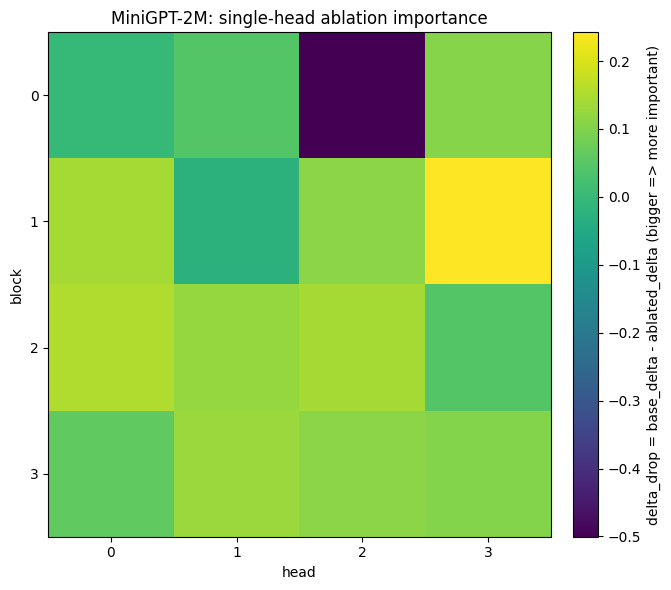

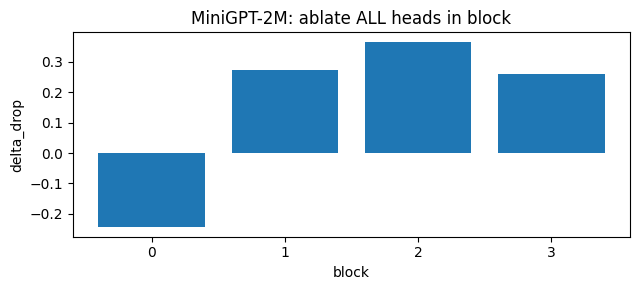

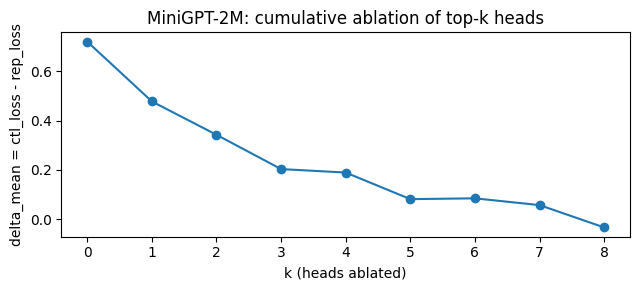


[MiniGPT-5p6M] baseline loss means:
 rep=2.0660  ctl=2.4029  delta=0.3368

[MiniGPT-5p6M] top heads (by delta_drop):
   block  head  delta_drop  delta_mean  rep_loss_increase  ctl_loss_increase
0      1     3    0.104127    0.232720           0.296249           0.192122
1      3     3    0.064063    0.272784           0.088410           0.024347
2      1     2    0.043849    0.292998           0.272647           0.228798
3      2     0    0.018548    0.318299           0.099646           0.081098
4      1     0    0.017649    0.319198           0.323412           0.305763
5      3     1    0.015424    0.321423           0.064697           0.049274
6      3     2    0.014866    0.321981           0.049339           0.034473
7      3     0    0.007947    0.328900           0.034993           0.027046
8      2     3   -0.005884    0.342731           0.078350           0.084234
9      2     1   -0.020484    0.357330           0.065376           0.085860

[MiniGPT-5p6M] blocks (all-head ab

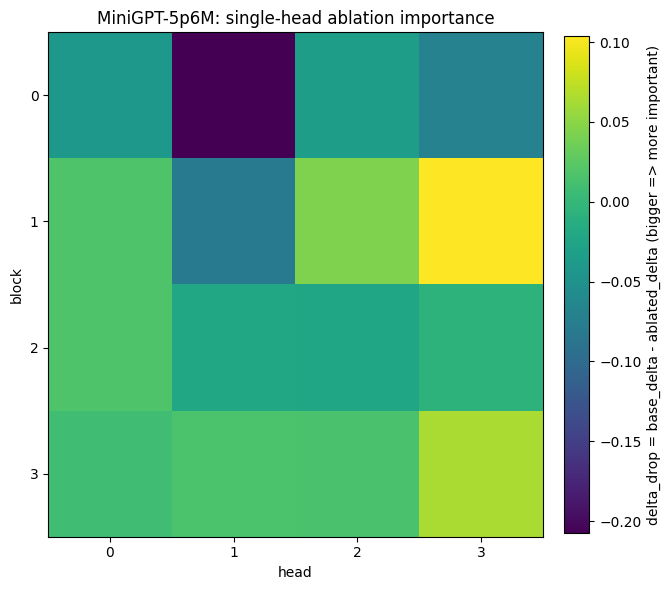

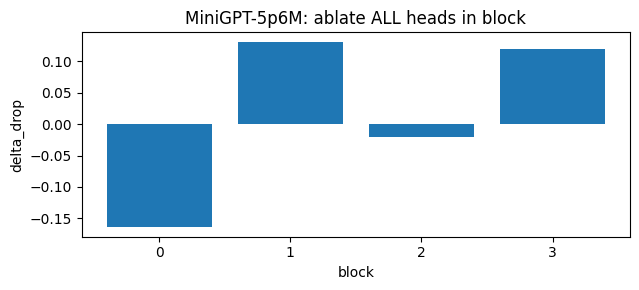

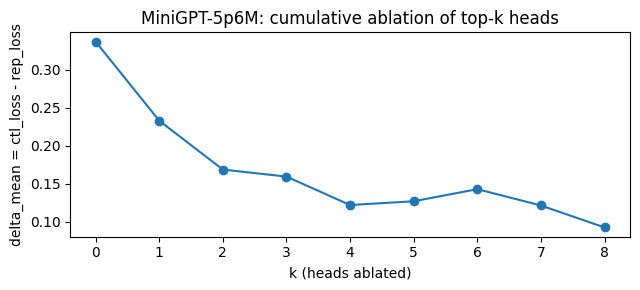

In [29]:
# ===================== RUN =====================
MICRO_BS = 100  # lower if OOM
L = 16
TOPK = 8

res_2M = run_ablation_study(model_2M, idx_rep_2M[:200], idx_ctl_2M[:200], name="MiniGPT-2M",   L=L, micro_bs=MICRO_BS, topk=TOPK)

res_5p6M = run_ablation_study(model_5p6M, idx_rep_5p6M[:200], idx_ctl_5p6M[:200], name="MiniGPT-5p6M",   L=L, micro_bs=MICRO_BS, topk=TOPK)

# # Quick comparison: which heads become more important later?
# dfA = res_2M["df_heads"][["block","head","delta_drop"]].rename(columns={"delta_drop":"drop_2M"})
# dfB = res_5p6M["df_heads"][["block","head","delta_drop"]].rename(columns={"delta_drop":"drop_5p6M"})
# dfC = dfA.merge(dfB, on=["block","head"], how="outer").fillna(0.0)
# dfC["drop_gain"] = dfC["drop_5p6M"] - dfC["drop_2M"]
# dfC = dfC.sort_values("drop_gain", ascending=False).reset_index(drop=True)

# print("\nHeads that gain importance in 5.6M vs 2M (drop_gain):")
# print(dfC.head(12))